# Extension Plan - Data Exploration

In this extension, I incorporate several additional datasets that provide insights into mortality rates due to respiratory diseases, asthma-related healthcare patterns (including both inpatient hospitalizations and emergency room visits), and the volume of respiratory-related medical procedures performed annually.

In this notebook, I perform an exploratory data analysis on the preprocessed health data to understand if/how the wildfires affect the health data.

In [1]:
#
#    IMPORTS
#

#    These are standard python modules. In case you do not have a python module, you should use `!pip install <module>`
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

First we load the smoke estimate data.

In [2]:
smoke_estimate_aqi_data = pd.read_csv("../Processed Data/smoke_estimate_with_year_aqi.csv", index_col=0)
smoke_estimate_aqi_data.rename(columns={"Fire_Year": "Year"}, inplace=True)
smoke_estimate_aqi_data

,Year,Smoke_Estimate,yearly_avg_aqi
0,1964,4.341713,5.386648
1,1965,4.000000,6.132075
2,1966,6.274285,4.641221
3,1967,7.693339,53.584158
4,1968,6.949404,63.722527
...,...,...,...
56,2020,64.000000,45.770657
57,2021,NaN,47.492489
58,2022,NaN,40.919786
59,2023,NaN,44.967453


### Dataset 1: CDC Wonder Mortality Data (Specifically due to respiratory diseases)

Here, I load the already [processed CDC Wonder data](../Processed%20Data/1999_2020_Mortality_Data.csv) and explore how the wildfires affect the mortality.

In [3]:
mortality_data = pd.read_csv("../Processed Data/1999_2020_Mortality_Data.csv")
mortality_data

,Year,Age Groups,Gender,Deaths
0,1999,0-24,Female,0
1,1999,0-24,Male,12
2,1999,25-64,Female,119
3,1999,25-64,Male,144
4,1999,65+,Female,1103
...,...,...,...,...
127,2020,0-24,Male,0
128,2020,25-64,Female,243
129,2020,25-64,Male,314
130,2020,65+,Female,1354


In [4]:
# Aggregated death values by year
mortality_aggregated_by_year = mortality_data.groupby('Year').agg({'Deaths': 'sum'}).reset_index()
mortality_aggregated_by_year.head()

,Year,Deaths
0,1999,2434
1,2000,2457
2,2001,2379
3,2002,2443
4,2003,2364


In [5]:
# Aggregated death values by year and age groups
mortality_aggregated_by_Age = mortality_data.groupby(['Year', 'Age Groups']).agg({'Deaths': 'sum'}).reset_index()
mortality_aggregated_by_Age.head()

,Year,Age Groups,Deaths
0,1999,0-24,12
1,1999,25-64,263
2,1999,65+,2159
3,2000,0-24,31
4,2000,25-64,296


In [6]:
# Aggregated death values by year and gender
mortality_aggregated_by_Gender = mortality_data.groupby(['Year', 'Gender']).agg({'Deaths': 'sum'}).reset_index()
mortality_aggregated_by_Gender.head()

,Year,Gender,Deaths
0,1999,Female,1222
1,1999,Male,1212
2,2000,Female,1250
3,2000,Male,1207
4,2001,Female,1219


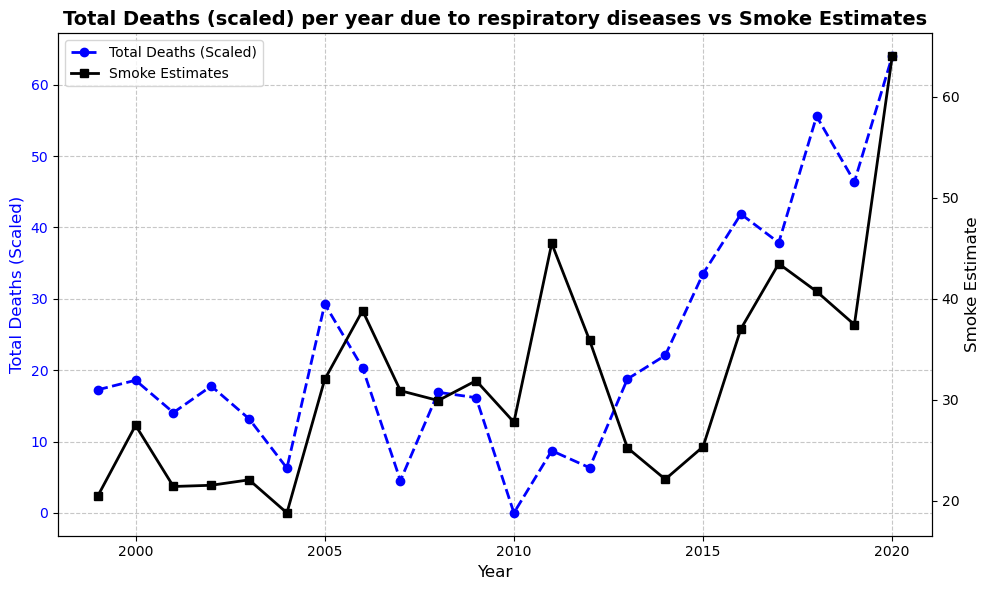

In [7]:
merged_mortality_by_year = pd.merge(mortality_aggregated_by_year, smoke_estimate_aqi_data, on='Year')

# Here I scale the deaths to be in the same range as the smoke estimate, i.e. between 0 and 64, to help with the visualization
min_deaths = merged_mortality_by_year['Deaths'].min()
max_deaths = merged_mortality_by_year['Deaths'].max()
merged_mortality_by_year['scaled_deaths'] = (merged_mortality_by_year['Deaths'] - min_deaths) / (max_deaths - min_deaths) * 64

fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot total deaths (scaled) on the primary y-axis
ax1.plot(merged_mortality_by_year['Year'], merged_mortality_by_year['scaled_deaths'], label='Total Deaths (Scaled)', color='blue', linestyle='--', linewidth=2, marker='o')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Deaths (Scaled)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
ax2.plot(merged_mortality_by_year['Year'], merged_mortality_by_year['Smoke_Estimate'], label='Smoke Estimates', color='black', linewidth=2, marker='s')
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10)
plt.title('Total Deaths (scaled) per year due to respiratory diseases vs Smoke Estimates', fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [8]:
# Calculate the correlation between 'Deaths' and 'Smoke_Estimate'
correlation = merged_mortality_by_year['scaled_deaths'].corr(merged_mortality_by_year['Smoke_Estimate'])
print(f"Correlation between Deaths and Smoke Estimate: {correlation}")

Correlation between Deaths and Smoke Estimate: 0.6245791977253838


From the chart and correlation scores above, we can see that deaths caused due to respiratory systems are correlated with wildfires, since as the smoke estimate increases, the deaths due to respiratory diseases tends to increase as well. We can also see that there is about 62.4% correlation between mortality and smoke estimate.

Now, that we have established a correlation between the smoke estimate and the total deaths, I decided to explore if a specific age group or gender is more strongly correlated to the smoke estimate and is affected by wildfires

   Year Age Groups  Deaths  Smoke_Estimate  yearly_avg_aqi  scaled_deaths
0  1999       0-24      12       20.482623       54.849141       0.286353
1  1999      25-64     263       20.482623       54.849141       6.275913
2  1999        65+    2159       20.482623       54.849141      51.519761
3  2000       0-24      31       27.482062       51.371458       0.739746
4  2000      25-64     296       27.482062       51.371458       7.063386


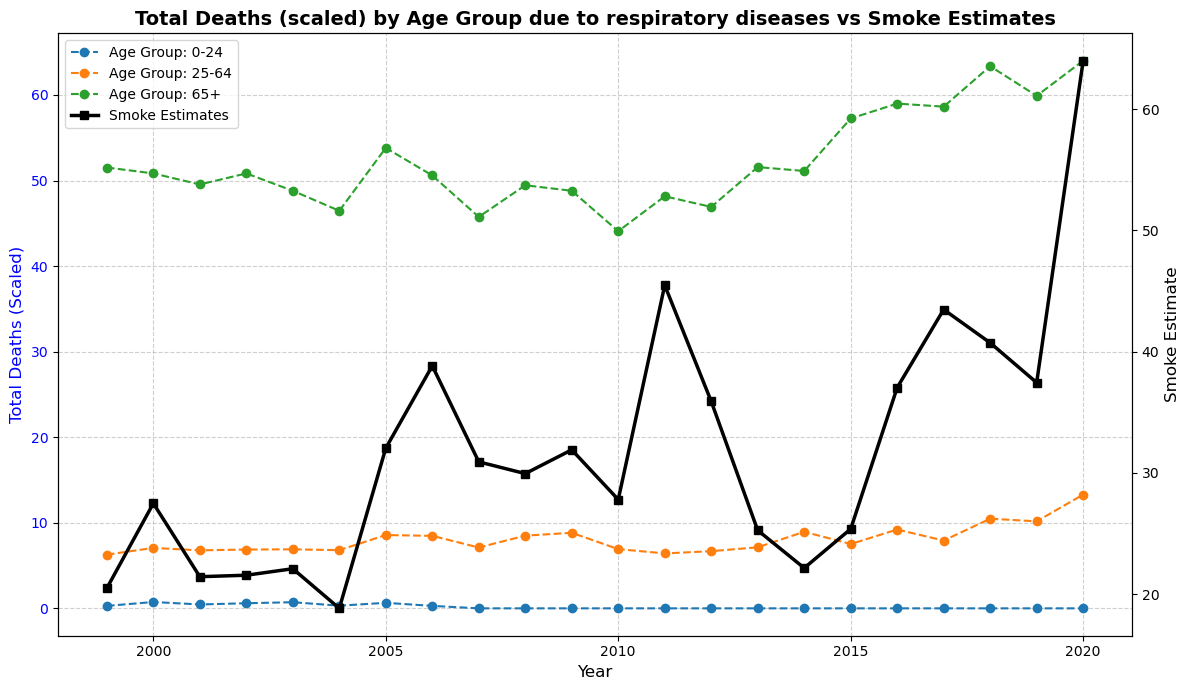

In [9]:
merged_mortality_by_age = pd.merge(mortality_aggregated_by_Age, smoke_estimate_aqi_data, on='Year')

# Here I scale the deaths to be in the same range as the smoke estimate, i.e. between 0 and 64, to help with the visualization
min_deaths = merged_mortality_by_age['Deaths'].min()
max_deaths = merged_mortality_by_age['Deaths'].max()
merged_mortality_by_age['scaled_deaths'] = (merged_mortality_by_age['Deaths'] - min_deaths) / (max_deaths - min_deaths) * 64

print(merged_mortality_by_age.head())


fig, ax1 = plt.subplots(figsize=(12, 7))
# Plot scaled deaths on the primary y-axis
for age_group in merged_mortality_by_age['Age Groups'].unique():
    age_group_data = merged_mortality_by_age[merged_mortality_by_age['Age Groups'] == age_group]
    ax1.plot(age_group_data['Year'], age_group_data['scaled_deaths'], label=f"Age Group: {age_group}", linestyle='--', marker='o', linewidth=1.5)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Deaths (Scaled)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.6)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
smoke_estimates_mean = merged_mortality_by_age.groupby('Year')['Smoke_Estimate'].mean()
ax2.plot(smoke_estimates_mean.index, smoke_estimates_mean, 
         color='black', marker = 's', label="Smoke Estimates", linewidth=2.5)
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10)

plt.title("Total Deaths (scaled) by Age Group due to respiratory diseases vs Smoke Estimates", fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [10]:
correlations = {}

# Loop through each age group and calculate the correlation with Smoke_Estimate
for age_group in mortality_aggregated_by_Age['Age Groups'].unique():
    age_group_data = merged_mortality_by_age[merged_mortality_by_age['Age Groups'] == age_group]
    correlation = age_group_data['scaled_deaths'].corr(age_group_data['Smoke_Estimate'])
    correlations[age_group] = correlation

for age_group, corr_value in correlations.items():
    print(f"Correlation between total deaths (scaled) and smoke estimate for age group {age_group}: {corr_value}")

Correlation between total deaths (scaled) and smoke estimate for age group 0-24: -0.4290947423616011
Correlation between total deaths (scaled) and smoke estimate for age group 25-64: 0.7046373379096696
Correlation between total deaths (scaled) and smoke estimate for age group 65+: 0.5806408476844029


In [11]:
print(merged_mortality_by_age[merged_mortality_by_age["Age Groups"] == "0-24"])

    Year Age Groups  Deaths  Smoke_Estimate  yearly_avg_aqi  scaled_deaths
0   1999       0-24      12       20.482623       54.849141       0.286353
3   2000       0-24      31       27.482062       51.371458       0.739746
6   2001       0-24      19       21.431882       49.290578       0.453393
9   2002       0-24      25       21.553465       53.063240       0.596570
12  2003       0-24      30       22.090325       53.228136       0.715884
15  2004       0-24      13       18.821474       45.149172       0.310216
18  2005       0-24      27       32.035572       47.915494       0.644295
21  2006       0-24      12       38.829661       47.896634       0.286353
24  2007       0-24       0       30.907773       47.032512       0.000000
27  2008       0-24       0       29.935974       47.256230       0.000000
30  2009       0-24       0       31.900473       41.146936       0.000000
33  2010       0-24       0       27.795122       41.402403       0.000000
36  2011       0-24      

   Year  Gender  Deaths  Smoke_Estimate  yearly_avg_aqi  scaled_deaths
0  1999  Female    1222       20.482623       54.849141      19.496689
1  1999    Male    1212       20.482623       54.849141      18.437086
2  2000  Female    1250       27.482062       51.371458      22.463576
3  2000    Male    1207       27.482062       51.371458      17.907285
4  2001  Female    1219       21.431882       49.290578      19.178808


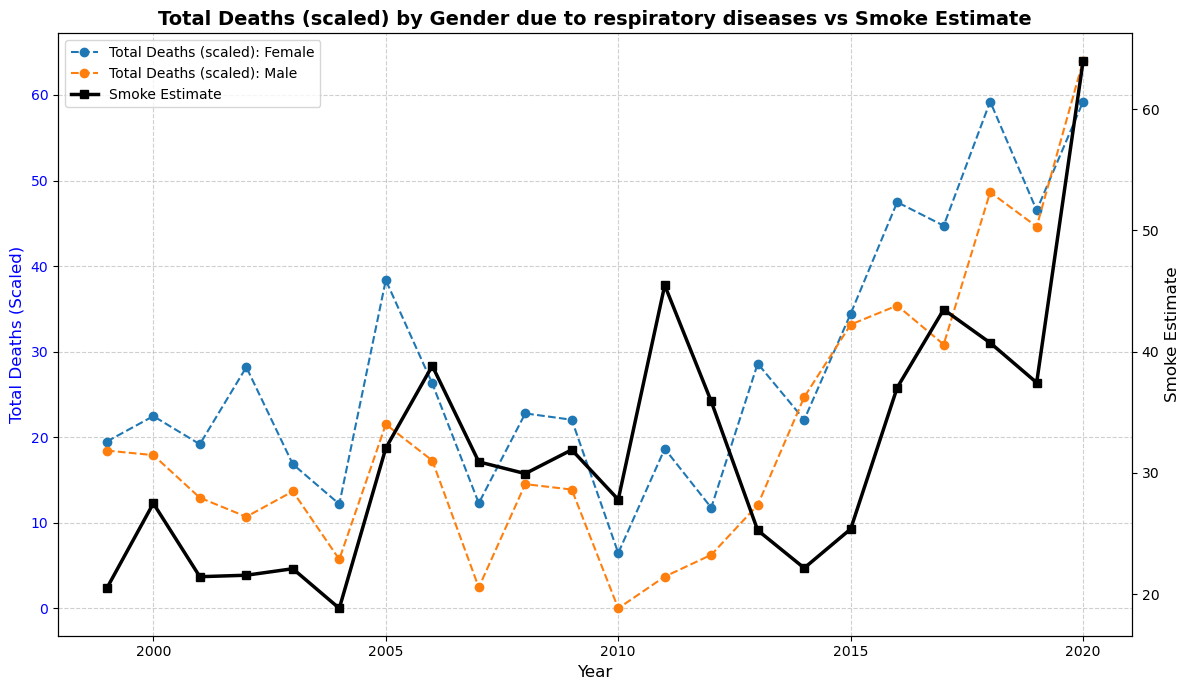

In [12]:
merged_mortality_by_gender = pd.merge(mortality_aggregated_by_Gender, smoke_estimate_aqi_data, on='Year')

# Here I scale the deaths to be in the same range as the smoke estimate, i.e. between 0 and 64, to help with the visualization
min_deaths = merged_mortality_by_gender['Deaths'].min()
max_deaths = merged_mortality_by_gender['Deaths'].max()
merged_mortality_by_gender['scaled_deaths'] = (merged_mortality_by_gender['Deaths'] - min_deaths) / (max_deaths - min_deaths) * 64

print(merged_mortality_by_gender.head())

fig, ax1 = plt.subplots(figsize=(12, 7))
# Plot total deaths (scaled) for each gender on the primary y-axis
for gender in merged_mortality_by_gender['Gender'].unique():
    gender_data = merged_mortality_by_gender[merged_mortality_by_gender['Gender'] == gender]
    ax1.plot(gender_data['Year'], gender_data['scaled_deaths'], label=f"Total Deaths (scaled): {gender}", linestyle='--', marker='o', linewidth=1.5)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Deaths (Scaled)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.6)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
smoke_estimates_mean = merged_mortality_by_gender.groupby('Year')['Smoke_Estimate'].mean()
ax2.plot(smoke_estimates_mean.index, smoke_estimates_mean, color='black', marker = 's', label="Smoke Estimate", linewidth=2.5)
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10)
plt.title("Total Deaths (scaled) by Gender due to respiratory diseases vs Smoke Estimate", fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [13]:
correlations = {}

# Loop through the gender and calculate the correlation with Smoke_Estimate
for gender in mortality_aggregated_by_Gender['Gender'].unique():
    gender_data = merged_mortality_by_gender[merged_mortality_by_gender['Gender'] == gender]
    correlation = gender_data['scaled_deaths'].corr(gender_data['Smoke_Estimate'])
    correlations[gender] = correlation

for gender, corr_value in correlations.items():
    print(f"Correlation between total deaths (scaled) and smoke estimate for {gender}: {corr_value}")

Correlation between total deaths (scaled) and smoke estimate for Female: 0.627287685329284
Correlation between total deaths (scaled) and smoke estimate for Male: 0.5994134518706573


### Dataset 2: ADHS Asthma-Related Inpatient Discharges and Emergency Visits Data

Here I take the already processed hospital inpatient discharges and emergency visits data and explore it's correlation with wildfires.

#### Emergency Visits Data

In [14]:
emergency_visit_data = pd.read_csv("../Processed Data/2003_2021_emergency_visits_data.csv")
emergency_visit_data.head()

,Year,Gender,Type of Record,"Asthma, All Mentions","Asthma, First Diagnosis"
0,2003,Female,Emergency Visits,8591,3358
1,2003,Male,Emergency Visits,6804,3336
2,2004,Female,Emergency Visits,18366,6273
3,2004,Male,Emergency Visits,14039,6245
4,2005,Female,Emergency Visits,23984,7346


In [15]:
# Aggregated emergency visits value by year for Asthma, All Mentions
all_mentions_EV_aggregated_by_year = emergency_visit_data.groupby('Year').agg({'Asthma, All Mentions': 'sum'}).reset_index()
all_mentions_EV_aggregated_by_year.head()

,Year,"Asthma, All Mentions"
0,2003,15395
1,2004,32405
2,2005,42054
3,2006,44403
4,2007,45697


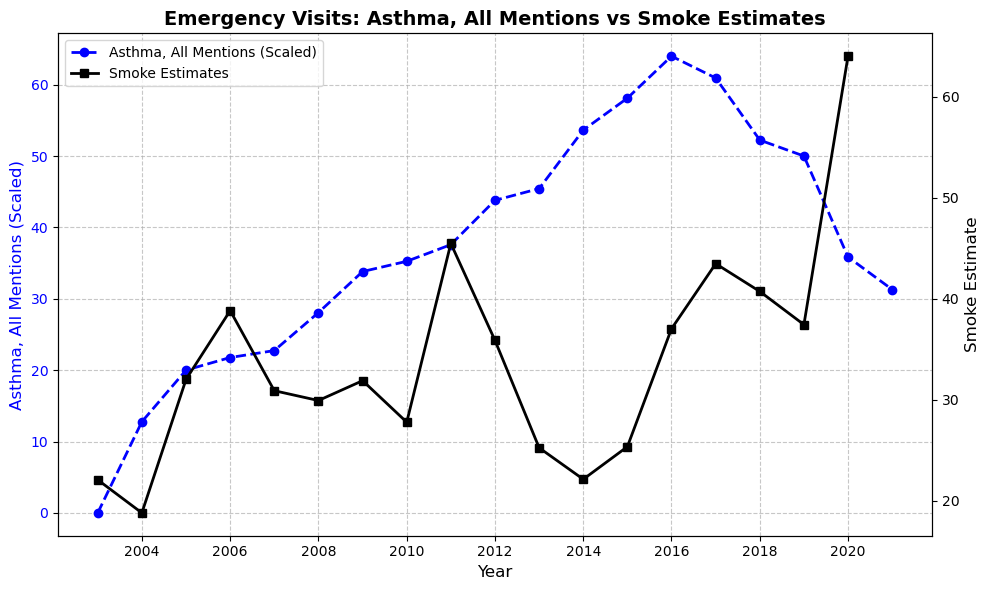

In [16]:
merged_all_mentions_EV_by_year = pd.merge(all_mentions_EV_aggregated_by_year, smoke_estimate_aqi_data, on='Year')
merged_all_mentions_EV_by_year['Year'] = pd.to_datetime(merged_all_mentions_EV_by_year['Year'], format='%Y')

# Scale the 'Asthma, All Mentions' data
min_deaths = merged_all_mentions_EV_by_year['Asthma, All Mentions'].min()
max_deaths = merged_all_mentions_EV_by_year['Asthma, All Mentions'].max()
merged_all_mentions_EV_by_year['scaled_deaths'] = (merged_all_mentions_EV_by_year['Asthma, All Mentions'] - min_deaths) / (max_deaths - min_deaths) * 64

fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot scaled Asthma, All mentions on the primary y-axis
ax1.plot(merged_all_mentions_EV_by_year['Year'], merged_all_mentions_EV_by_year['scaled_deaths'], label='Asthma, All Mentions (Scaled)', color='blue', linestyle='--', linewidth=2, marker='o')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Asthma, All Mentions (Scaled)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
ax2.plot(merged_all_mentions_EV_by_year['Year'], merged_all_mentions_EV_by_year['Smoke_Estimate'], label='Smoke Estimates', color='black', linewidth=2, marker='s')
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10)
plt.title('Emergency Visits: Asthma, All Mentions vs Smoke Estimates', fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [17]:
# Calculate the correlation between Asthma, all mentions and 'Smoke_Estimate'
correlation = merged_all_mentions_EV_by_year['scaled_deaths'].corr(merged_all_mentions_EV_by_year['Smoke_Estimate'])
print(f"Correlation between emergency visits, Asthma all mentions and Smoke Estimate: {correlation}")

Correlation between emergency visits, Asthma all mentions and Smoke Estimate: 0.26580659544047486


In [18]:
# Aggregated emergency visits value by year for Asthma, First Diagnosis
first_diagnosis_EV_aggregated_by_year = emergency_visit_data.groupby('Year').agg({'Asthma, First Diagnosis': 'sum'}).reset_index()
first_diagnosis_EV_aggregated_by_year.head()

,Year,"Asthma, First Diagnosis"
0,2003,6694
1,2004,12518
2,2005,14559
3,2006,13472
4,2007,14646


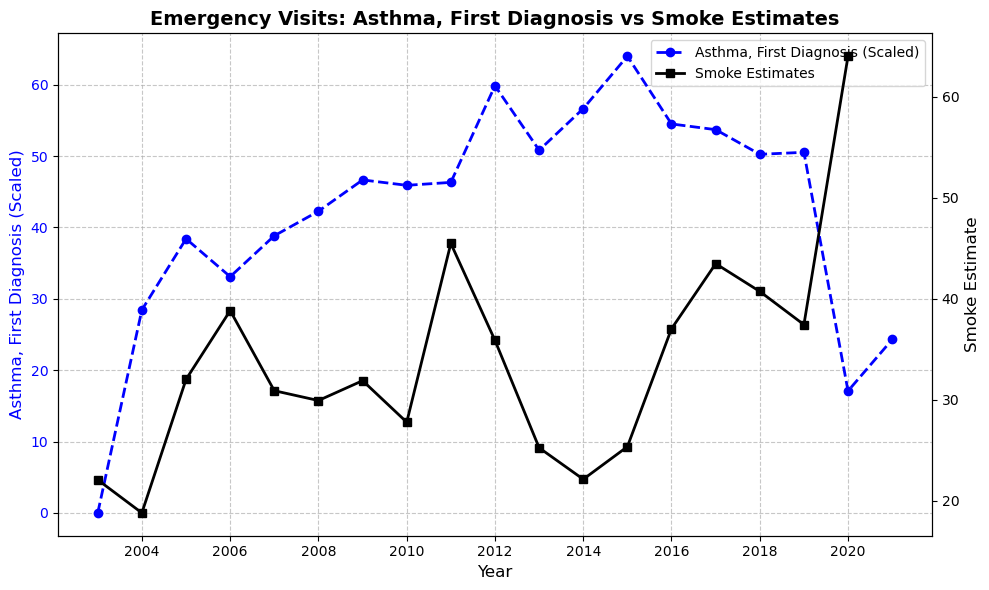

In [19]:
merged_first_diagnosis_EV_by_year = pd.merge(first_diagnosis_EV_aggregated_by_year, smoke_estimate_aqi_data, on='Year')
merged_first_diagnosis_EV_by_year['Year'] = pd.to_datetime(merged_first_diagnosis_EV_by_year['Year'], format='%Y')

# Scale the 'Asthma, First Diagnosis' data
min_deaths = merged_first_diagnosis_EV_by_year['Asthma, First Diagnosis'].min()
max_deaths = merged_first_diagnosis_EV_by_year['Asthma, First Diagnosis'].max()
merged_first_diagnosis_EV_by_year['scaled_deaths'] = (merged_first_diagnosis_EV_by_year['Asthma, First Diagnosis'] - min_deaths) / (max_deaths - min_deaths) * 64


fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot scaled Asthma, First Diagnosis on the primary y-axis
ax1.plot(merged_first_diagnosis_EV_by_year['Year'], merged_first_diagnosis_EV_by_year['scaled_deaths'], label='Asthma, First Diagnosis (Scaled)', color='blue', linestyle='--', linewidth=2, marker='o')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Asthma, First Diagnosis (Scaled)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
ax2.plot(merged_first_diagnosis_EV_by_year['Year'], merged_first_diagnosis_EV_by_year['Smoke_Estimate'], label='Smoke Estimates', color='black', linewidth=2, marker='s')
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10)
plt.title('Emergency Visits: Asthma, First Diagnosis vs Smoke Estimates', fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [20]:
# Calculate the correlation between 'Asthma, first diagnosis' and 'Smoke_Estimate'
correlation = merged_first_diagnosis_EV_by_year['scaled_deaths'].corr(merged_first_diagnosis_EV_by_year['Smoke_Estimate'])
print(f"Correlation between emergency visits, Asthma first diagnosis and Smoke Estimate:  {correlation}")

Correlation between emergency visits, Asthma first diagnosis and Smoke Estimate:  -0.07764293338887897


#### Inpatient Discharges Data

In [21]:
inpatient_discharges_data = pd.read_csv("../Processed Data/2003_2021_inpatient_discharge_data.csv")
inpatient_discharges_data.head()

,Year,Gender,Type of Record,"Asthma, All Mentions","Asthma, First Diagnosis"
0,2003,Female,Inpatient Discharge,6540,1168
1,2003,Male,Inpatient Discharge,3517,1066
2,2004,Female,Inpatient Discharge,13729,2318
3,2004,Male,Inpatient Discharge,7321,1836
4,2005,Female,Inpatient Discharge,14963,2444


In [22]:
# Aggregated inpatient discharges data by year for Asthma, All Mentions
inpatient_discharges_AM_aggregated_by_year = inpatient_discharges_data.groupby('Year').agg({'Asthma, All Mentions': 'sum'}).reset_index()
inpatient_discharges_AM_aggregated_by_year.head()

,Year,"Asthma, All Mentions"
0,2003,10057
1,2004,21050
2,2005,23037
3,2006,23588
4,2007,24349


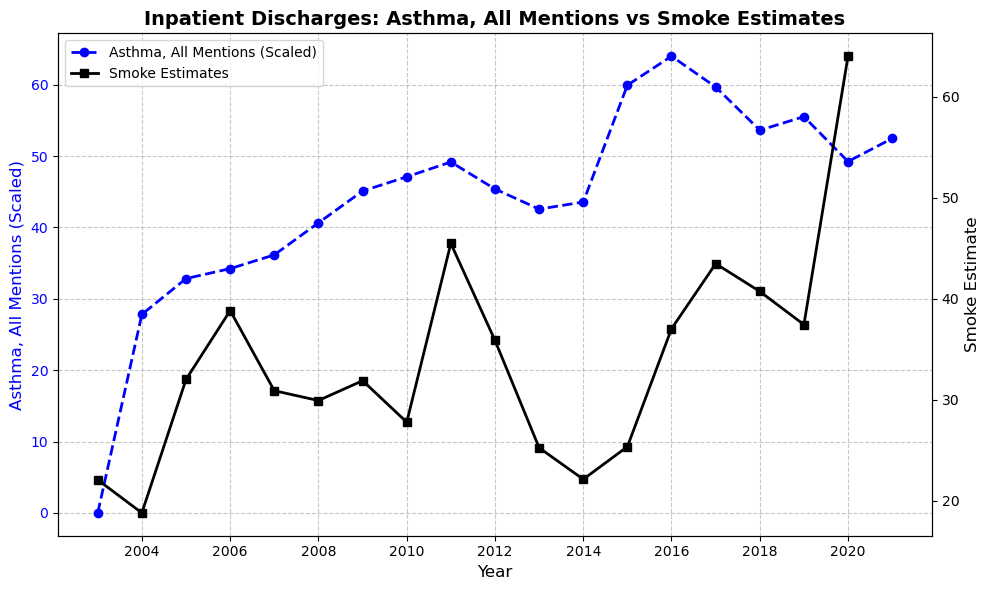

In [23]:
merged_all_mentions_ID_by_year = pd.merge(inpatient_discharges_AM_aggregated_by_year, smoke_estimate_aqi_data, on='Year')
merged_all_mentions_ID_by_year['Year'] = pd.to_datetime(merged_all_mentions_ID_by_year['Year'], format='%Y')

# Scale the 'Asthma, All Mentions' data
min_deaths = merged_all_mentions_ID_by_year['Asthma, All Mentions'].min()
max_deaths = merged_all_mentions_ID_by_year['Asthma, All Mentions'].max()
merged_all_mentions_ID_by_year['scaled_deaths'] = (merged_all_mentions_ID_by_year['Asthma, All Mentions'] - min_deaths) / (max_deaths - min_deaths) * 64

fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot scaled Asthma, All Mentions on the primary y-axis
ax1.plot(merged_all_mentions_ID_by_year['Year'], merged_all_mentions_ID_by_year['scaled_deaths'], label='Asthma, All Mentions (Scaled)', color='blue', linestyle='--', linewidth=2, marker='o')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Asthma, All Mentions (Scaled)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
ax2.plot(merged_all_mentions_ID_by_year['Year'], merged_all_mentions_ID_by_year['Smoke_Estimate'], label='Smoke Estimates', color='black', linewidth=2, marker='s')
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10)
plt.title('Inpatient Discharges: Asthma, All Mentions vs Smoke Estimates', fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [24]:
# Calculate the correlation between 'Asthma, All Mentions' for Inpatient Discharges and 'Smoke_Estimate'
correlation = merged_all_mentions_ID_by_year['scaled_deaths'].corr(merged_all_mentions_ID_by_year['Smoke_Estimate'])
print(f"Correlation between inpatient discharges, Asthma all mentions and Smoke Estimate: {correlation}")

Correlation between inpatient discharges, Asthma all mentions and Smoke Estimate: 0.43755101385252615


In [25]:
# Aggregated inpatient discharges data by year for Asthma, First Diagnosis
inpatient_discharges_FD_aggregated_by_year = inpatient_discharges_data.groupby('Year').agg({'Asthma, First Diagnosis': 'sum'}).reset_index()
inpatient_discharges_FD_aggregated_by_year.head()

,Year,"Asthma, First Diagnosis"
0,2003,2234
1,2004,4154
2,2005,4347
3,2006,4080
4,2007,4273


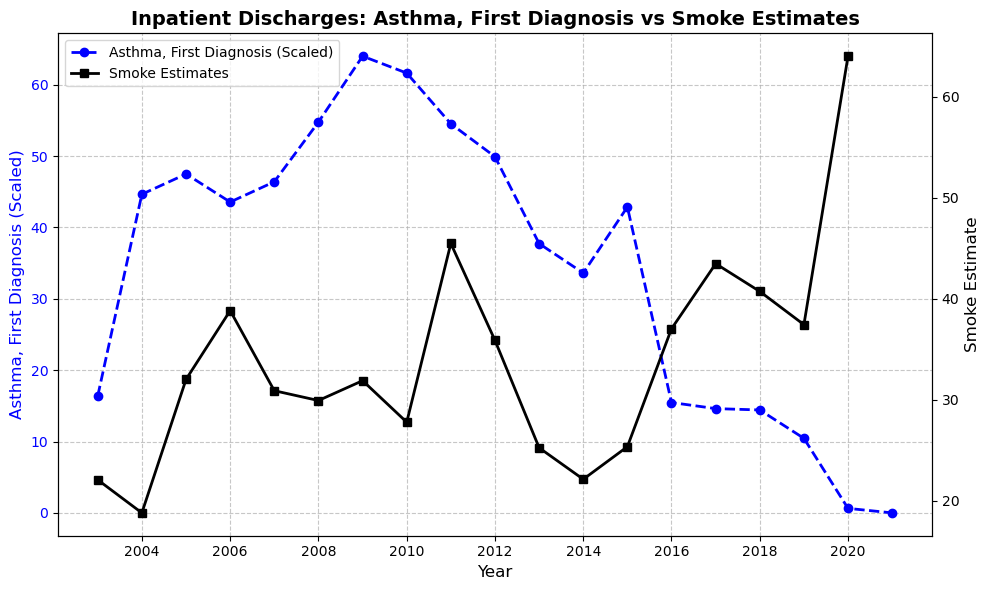

In [26]:
merged_first_diagnosis_ID_by_year = pd.merge(inpatient_discharges_FD_aggregated_by_year, smoke_estimate_aqi_data, on='Year')
merged_first_diagnosis_ID_by_year['Year'] = pd.to_datetime(merged_first_diagnosis_ID_by_year['Year'], format='%Y')

# Scale the 'Asthma, First Diagnosis' data
min_deaths = merged_first_diagnosis_ID_by_year['Asthma, First Diagnosis'].min()
max_deaths = merged_first_diagnosis_ID_by_year['Asthma, First Diagnosis'].max()
merged_first_diagnosis_ID_by_year['scaled_deaths'] = (merged_first_diagnosis_ID_by_year['Asthma, First Diagnosis'] - min_deaths) / (max_deaths - min_deaths) * 64

fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot scaled Asthma, First Diagnosis on the primary y-axis
ax1.plot(merged_first_diagnosis_ID_by_year['Year'], merged_first_diagnosis_ID_by_year['scaled_deaths'], label='Asthma, First Diagnosis (Scaled)', color='blue', linestyle='--', linewidth=2, marker='o')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Asthma, First Diagnosis (Scaled)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
ax2.plot(merged_first_diagnosis_ID_by_year['Year'], merged_first_diagnosis_ID_by_year['Smoke_Estimate'], label='Smoke Estimates', color='black', linewidth=2, marker='s')
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
plt.title('Inpatient Discharges: Asthma, First Diagnosis vs Smoke Estimates', fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [27]:
# Calculate the correlation between 'Asthma, First Diagnosis' and 'Smoke_Estimate'
correlation = merged_first_diagnosis_ID_by_year['scaled_deaths'].corr(merged_first_diagnosis_ID_by_year['Smoke_Estimate'])
print(f"Correlation between inpatient discharges, Asthma first diagnosis and Smoke Estimate: {correlation}")

Correlation between inpatient discharges, Asthma first diagnosis and Smoke Estimate: -0.4462426752180413


### Dataset 3: ADHS Medical Procedures Data

Here I take the already processed procedures data and explore the effects of wildfires on it, if any.

In [28]:
respiratory_operations_data = pd.read_csv("../Processed Data/2000_2020_respiratory_system_operations.csv")
respiratory_operations_data

,Year,Total
0,2000,7964
1,2001,8953
2,2002,9507
3,2003,10061
4,2004,10951
5,2005,11804
6,2006,12709
7,2007,13075
8,2008,13985
9,2009,14571


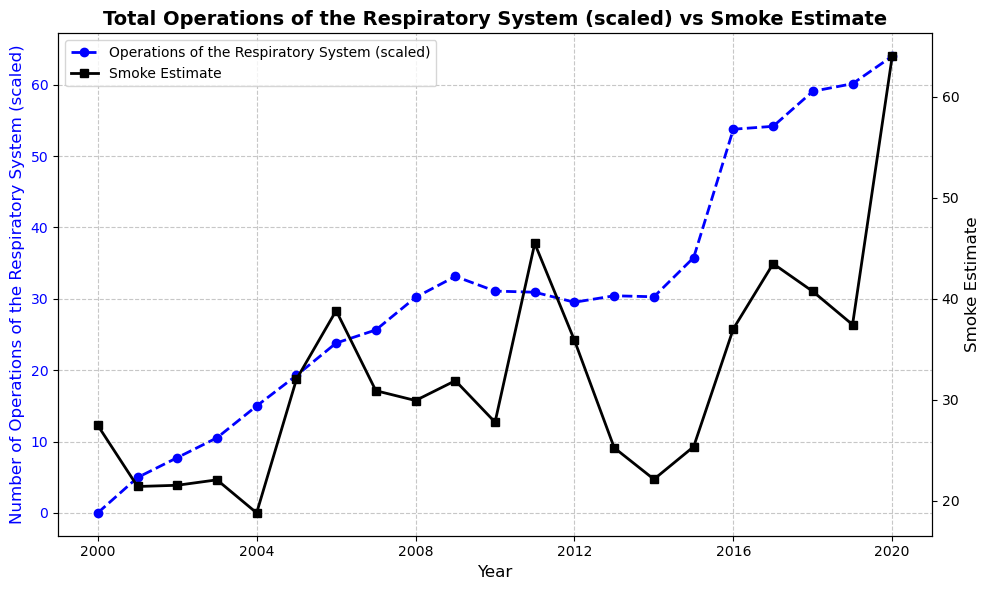

In [ ]:
merged_respiratory_operations_data = pd.merge(respiratory_operations_data, smoke_estimate_aqi_data, on='Year', how='inner')

# Scale 'Total' (number of procedures) to range 0-64 similar to the smoke estimate
min_procedures = merged_respiratory_operations_data['Total'].min()
max_procedures = merged_respiratory_operations_data['Total'].max()
merged_respiratory_operations_data['scaled_procedures'] = (merged_respiratory_operations_data['Total'] - min_procedures) / (max_procedures - min_procedures) * 64

# Convert 'Year' to datetime
merged_respiratory_operations_data['Year'] = pd.to_datetime(merged_respiratory_operations_data['Year'], format='%Y')

_, ax1 = plt.subplots(figsize=(10, 6))
# Plot the scaled number of procedures on the primary y-axis
ax1.plot(merged_respiratory_operations_data['Year'], merged_respiratory_operations_data['scaled_procedures'], marker='o', linestyle='--', color='blue', label='Operations of the Respiratory System (scaled)', linewidth=2)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Operations of the Respiratory System (scaled)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
ax2.plot(merged_respiratory_operations_data['Year'], merged_respiratory_operations_data['Smoke_Estimate'], marker='s', color='black', label='Smoke Estimate', linewidth=2)
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
plt.title('Total Operations of the Respiratory System (scaled) vs Smoke Estimate', fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [30]:
correlation = merged_respiratory_operations_data['scaled_procedures'].corr(merged_respiratory_operations_data['Smoke_Estimate'])
print(f"Correlation between Operations of the Respiratory System and smoke estimate: {correlation}")

Correlation between Operations of the Respiratory System and smoke estimate: 0.7221095334570489


In [31]:
respiratory_therapy_data = pd.read_csv("../Processed Data/2000_2015_respiratory_therapy.csv")
respiratory_therapy_data

,Year,Total
0,2000,6788
1,2001,7220
2,2002,7801
3,2003,10682
4,2004,9819
5,2005,11796
6,2006,12290
7,2007,12970
8,2008,14531
9,2009,16002


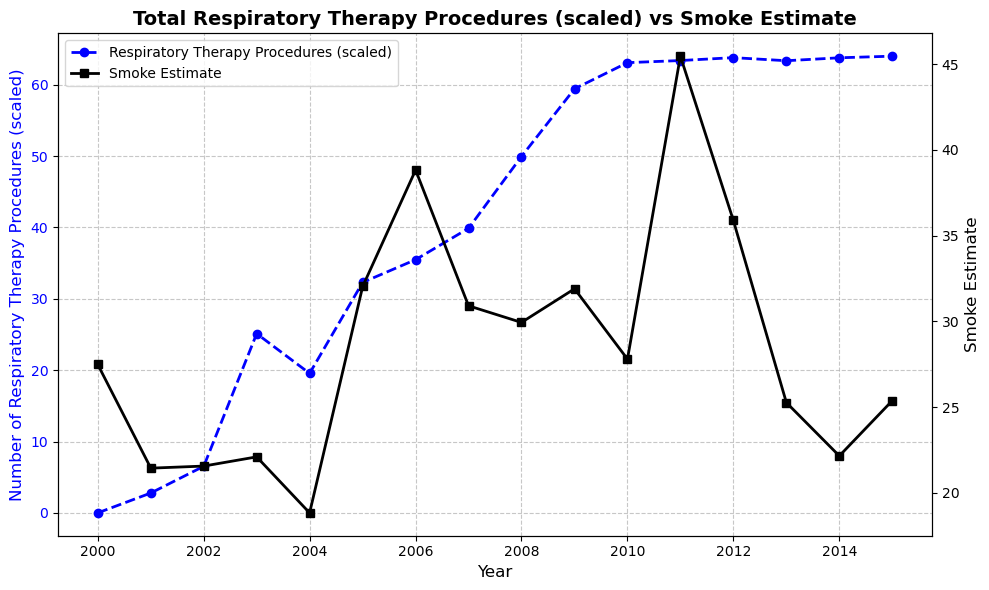

In [ ]:
merged_respiratory_therapy_data = pd.merge(respiratory_therapy_data, smoke_estimate_aqi_data, on='Year', how='inner')

# Scale 'Total' (number of procedures) to range 0-64 similar to the smoke estimate
min_procedures = merged_respiratory_therapy_data['Total'].min()
max_procedures = merged_respiratory_therapy_data['Total'].max()
merged_respiratory_therapy_data['scaled_procedures'] = (merged_respiratory_therapy_data['Total'] - min_procedures) / (max_procedures - min_procedures) * 64

# Convert 'Year' to datetime
merged_respiratory_therapy_data['Year'] = pd.to_datetime(merged_respiratory_therapy_data['Year'], format='%Y')

# Create the plot
_, ax1 = plt.subplots(figsize=(10, 6))

# Plot the scaled number of procedures on the primary y-axis
ax1.plot(merged_respiratory_therapy_data['Year'], merged_respiratory_therapy_data['scaled_procedures'], marker='o', linestyle='--', color='blue', 
    label='Respiratory Therapy Procedures (scaled)', linewidth=2)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Respiratory Therapy Procedures (scaled)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a secondary y-axis for smoke estimates
ax2 = ax1.twinx()
ax2.plot(merged_respiratory_therapy_data['Year'], merged_respiratory_therapy_data['Smoke_Estimate'], marker='s', color='black', label='Smoke Estimate', linewidth=2)
ax2.set_ylabel('Smoke Estimate', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
plt.title('Total Respiratory Therapy Procedures (scaled) vs Smoke Estimate', fontsize=14, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()


In [33]:
correlation = merged_respiratory_therapy_data['scaled_procedures'].corr(merged_respiratory_therapy_data['Smoke_Estimate'])
print(f"Correlation between the number of Respiratory Therapies and smoke estimate: {correlation}")

Correlation between the number of Respiratory Therapies and smoke estimate: 0.4210967254551776
